Epoch 0, Loss: 24050.62890625
Epoch 1000, Loss: 15.736854553222656
Epoch 2000, Loss: 3.576263666152954
Epoch 3000, Loss: 1.7400790452957153
Epoch 4000, Loss: 1.8362377882003784
Epoch 5000, Loss: 1.6164199113845825
Epoch 6000, Loss: 0.7222046852111816
Epoch 7000, Loss: 1.1264536380767822
Epoch 8000, Loss: 0.797240674495697
Epoch 9000, Loss: 0.9245268106460571


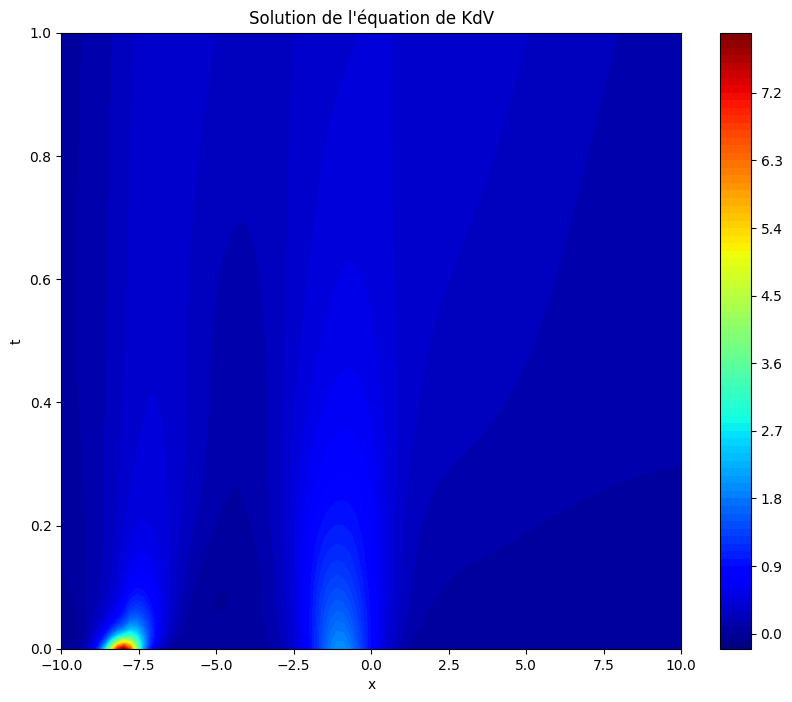

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Définition de l'équation KdV
def kdv_equation(x, t, u, u_t, u_x, u_xxx):
    return u_t + 6*u*u_x + u_xxx

# Génération de données de formation
def initial_condition(x):
    return 8*(np.cosh(2 * (x+8)))**-2 + 2*(np.cosh(1 * (x+1)))**-2

# Génération de données de la grille
L = 20.0
N = 100  # Nombre de points de grille pour une meilleure résolution
T = 1.0
x = np.linspace(-L/2, L/2, N)
t = np.linspace(0, T, N)
X, T = np.meshgrid(x, t)
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]

# Condition initiale
u0 = initial_condition(x)

# Construction du modèle PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    
    def forward(self, X):
        for i in range(len(self.layers)-1):
            X = torch.tanh(self.layers[i](X))
        return self.layers[-1](X)

# Définition de la perte
def loss(model, X_f, X_u, u, weight_ic=1.0):
    X_f.requires_grad = True
    u_pred = model(X_f)
    u_pred_x = torch.autograd.grad(u_pred, X_f, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0][:, 0]
    u_pred_t = torch.autograd.grad(u_pred, X_f, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0][:, 1]
    u_pred_xx = torch.autograd.grad(u_pred_x, X_f, grad_outputs=torch.ones_like(u_pred_x), create_graph=True)[0][:, 0]
    u_pred_xxx = torch.autograd.grad(u_pred_xx, X_f, grad_outputs=torch.ones_like(u_pred_xx), create_graph=True)[0][:, 0]
    
    f_pred = kdv_equation(X_f[:, 0], X_f[:, 1], u_pred, u_pred_t, u_pred_x, u_pred_xxx)
    u_pred_ic = model(X_u)
    loss_u = torch.mean((u - u_pred_ic)**2)
    loss_f = torch.mean(f_pred**2)
    return weight_ic * loss_u + loss_f

# Génération des données de formation
X_f_train = torch.tensor(np.hstack((X_flat, T_flat)), dtype=torch.float32)
X_u_train = torch.tensor(np.hstack((x[:, None], np.zeros_like(x[:, None]))), dtype=torch.float32)
u_train = torch.tensor(u0[:, None], dtype=torch.float32)

# Entraînement du modèle PINN
layers = [2, 20, 20, 20, 50,50,50,1]  # Réseau plus large
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Utiliser des mini-batchs pour l'entraînement
batch_size = 1000  # Taille du mini-batch
epochs = 10000  # Augmenter le nombre d'époques

# Pondération de la perte pour la condition initiale
weight_ic = 10000.0

for epoch in range(epochs):
    permutation = torch.randperm(X_f_train.size()[0])
    for i in range(0, X_f_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_X_f = X_f_train[indices]
        optimizer.zero_grad()
        train_loss = loss(model, batch_X_f, X_u_train, u_train, weight_ic)
        train_loss.backward()
        optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

# Prédiction
u_pred = model(torch.tensor(np.hstack((X_flat, T_flat)), dtype=torch.float32)).detach().numpy().reshape(N, N)

# Affichage des résultats
plt.figure(figsize=(10, 8))
plt.contourf(X, T, u_pred, levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution de l\'équation de KdV')
plt.show()


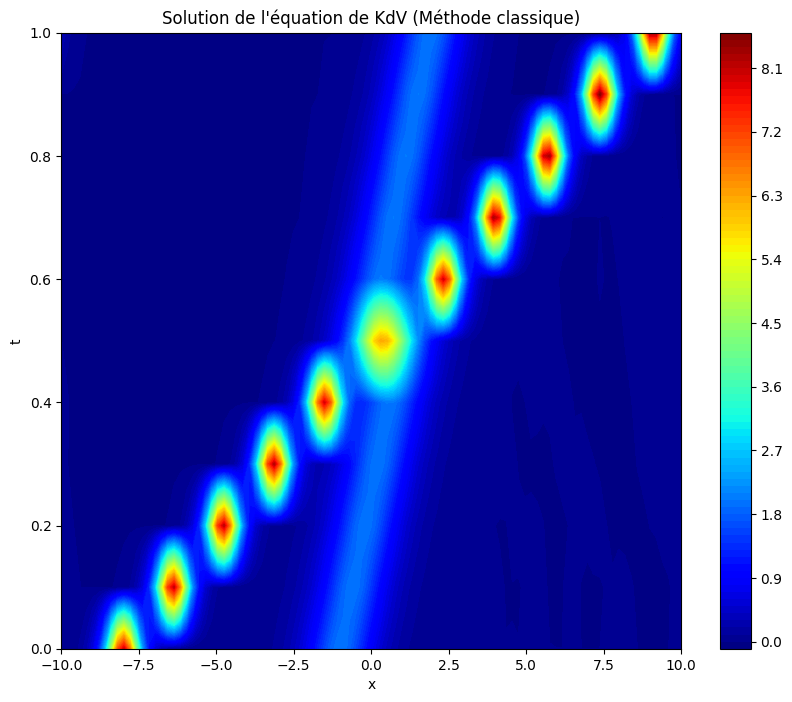

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
N = 100
x = np.linspace(-10, 10, N)
delta_x = x[1] - x[0]
delta_k = 2 * np.pi / (N * delta_x)
k = np.concatenate([np.arange(0, N/2+1)*delta_k, np.arange(-N/2+1, 0)*delta_k])

c = 1
u = 8*(np.cosh(2 * (x+8)))**-2+2*(np.cosh(1 * (x+1)))**-2

delta_t = 0.4 / N**2
tmax = 1
nmax = round(tmax / delta_t)

U = np.fft.fft(u)

# Stockage des solutions
u_hist = [u.copy()]
t_hist = [0]

for n in range(nmax):
    # Première étape : résoudre la partie linéaire
    U = U * np.exp(1j * k**3 * delta_t)
    # Deuxième étape : résoudre la partie non linéaire
    U = U - delta_t * (3j * k * np.fft.fft(np.real(np.fft.ifft(U))**2))
    # Sauvegarder la solution à chaque pas de temps
    if (n+1) % (nmax // 10) == 0:  # Ajuster la fréquence de sauvegarde pour éviter un grand nombre de points
        u_current = np.real(np.fft.ifft(U))
        u_hist.append(u_current)
        t_hist.append((n+1) * delta_t)

# Convertir l'historique des solutions en un tableau numpy pour faciliter l'affichage
u_hist = np.array(u_hist)

# Affichage des résultats
X, T = np.meshgrid(x, t_hist)

fig, ax = plt.subplots(figsize=(10, 8))
c = ax.contourf(X, T, u_hist, levels=100, cmap='jet')
fig.colorbar(c, ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title("Solution de l'équation de KdV (Méthode classique)")
plt.show()


Epoch 0, Loss: 49449.36328125
Epoch 1000, Loss: 2106.64990234375
Epoch 2000, Loss: 1277.481201171875
Epoch 3000, Loss: 924.192138671875
Epoch 4000, Loss: 697.3966064453125
Epoch 5000, Loss: 589.6803588867188
Epoch 6000, Loss: 521.2142944335938
Epoch 7000, Loss: 481.3636474609375
Epoch 8000, Loss: 522.7235717773438
Epoch 9000, Loss: 455.5848693847656


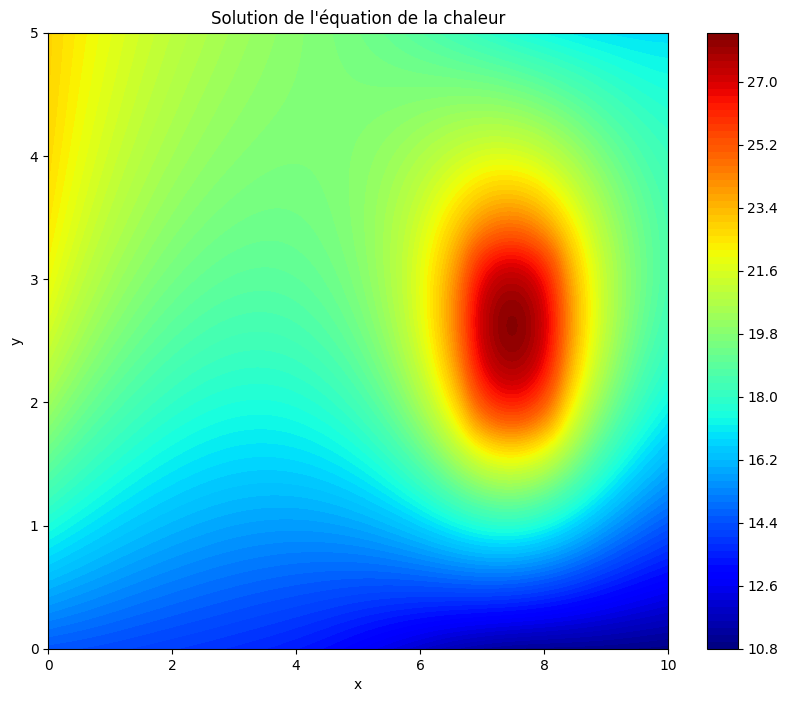

In [155]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Définir la géométrie et le domaine basé sur le fichier `.geo`
dx_Brick = 10.0
dy_Brick = 5.0
dx_Win1 = 2.0
dy_Win1 = 1.0
dx_Win2 = 1.5
dy_Win2 = 1.5
e_layer = 0.1
Flag_Regularization = True

# Brick coordinates
x_Brick = np.linspace(0, dx_Brick, 200)
y_Brick = np.linspace(0, dy_Brick, 100)
X_Brick, Y_Brick = np.meshgrid(x_Brick, y_Brick)
X_Brick_flat = X_Brick.flatten()[:, None]
Y_Brick_flat = Y_Brick.flatten()[:, None]

# Définir les fenêtres avec des sources chaudes et froides
win1_center = (2.5, 2.5)
win2_center = (7.5, 2.5)

def in_window1(x, y):
    return (win1_center[0] - dx_Win1 / 2 <= x <= win1_center[0] + dx_Win1 / 2) and (win1_center[1] - dy_Win1 / 2 <= y <= win1_center[1] + dy_Win1 / 2)

def in_window2(x, y):
    return (win2_center[0] - dx_Win2 / 2 <= x <= win2_center[0] + dx_Win2 / 2) and (win2_center[1] - dy_Win2 / 2 <= y <= win2_center[1] + dy_Win2 / 2)

# Définir les conditions initiales et aux limites
def initial_condition(x, y):
    return np.zeros((len(x), 1))

def dirichlet_condition(x, y):
    return np.full((len(x), 1), 20)  # T_Dirichlet = 20

def convection_condition(x, y):
    return np.full((len(x), 1), 20)  # T_Ambiance = 20

def source_condition(x, y):
    return np.array([0 if in_window1(xi, yi) else 1000 if in_window2(xi, yi) else 0 for xi, yi in zip(x, y)]).reshape(-1, 1)

# Définir les paramètres du problème thermique
lambda_val = 50.0  # Steel
thickness = 1.0
Qsource = 1000.0
h = 10
Tinf = 20.0

# Définir le modèle PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, X):
        for i in range(len(self.layers) - 1):
            X = torch.tanh(self.layers[i](X))
        return self.layers[-1](X)

# Définir la fonction de perte
def loss(model, X_f, X_u, u, weight_ic=1.0):
    X_f.requires_grad = True
    u_pred = model(X_f)
    T = u_pred[:, 0]
    
    T_x = torch.autograd.grad(T, X_f, grad_outputs=torch.ones_like(T), create_graph=True)[0][:, 0]
    T_y = torch.autograd.grad(T, X_f, grad_outputs=torch.ones_like(T), create_graph=True)[0][:, 1]
    
    T_xx = torch.autograd.grad(T_x, X_f, grad_outputs=torch.ones_like(T_x), create_graph=True)[0][:, 0]
    T_yy = torch.autograd.grad(T_y, X_f, grad_outputs=torch.ones_like(T_y), create_graph=True)[0][:, 1]

    # Equation de la chaleur modifiée
    source_term = torch.tensor(source_condition(X_f[:, 0].detach().numpy(), X_f[:, 1].detach().numpy()), dtype=torch.float32)
    f_pred = lambda_val * (T_xx + T_yy) + source_term.squeeze()
    
    # Conditions aux limites Dirichlet
    bc_pred_dirichlet = model(X_u)
    bc_loss_dirichlet = torch.mean((bc_pred_dirichlet - torch.tensor(dirichlet_condition(X_u[:, 0].detach().numpy(), X_u[:, 1].detach().numpy()), dtype=torch.float32)) ** 2)
    
    # Conditions aux limites Neumann (homogène)
    bc_loss_neumann = torch.tensor(0.0)  # Neumann homogène, donc la perte est nulle
    
    # Conditions initiales
    ic_pred = model(torch.cat((X_f[:, 0:1], torch.zeros_like(X_f[:, 1:2])), dim=1))
    ic_loss = torch.mean((ic_pred - torch.tensor(initial_condition(X_f[:, 0].detach().numpy(), X_f[:, 1].detach().numpy()), dtype=torch.float32)) ** 2)
    
    # Terme de convection
    conv_loss = torch.mean(h * (T - Tinf) ** 2)
    
    # Fonction de perte totale
    loss = torch.mean(f_pred ** 2) + weight_ic * ic_loss + bc_loss_dirichlet + bc_loss_neumann + conv_loss
    return loss

# Génération des données de formation
X_f_train = torch.tensor(np.hstack((X_Brick_flat, Y_Brick_flat)), dtype=torch.float32)
X_u_train = torch.tensor(np.hstack((X_Brick_flat, Y_Brick_flat)), dtype=torch.float32)
u_train = torch.tensor(initial_condition(X_Brick_flat, Y_Brick_flat), dtype=torch.float32)

# Créer le modèle et l'optimiseur
model = PINN([2, 50, 50, 50, 1])  # 2 entrées (x, y) et 1 sortie (T)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    train_loss = loss(model, X_f_train, X_u_train, u_train)
    train_loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

# Prédiction
output = model(torch.tensor(np.hstack((X_Brick_flat, Y_Brick_flat)), dtype=torch.float32)).detach().numpy().reshape(100, 200)

# Affichage des résultats
# Visualisation pour une tranche 2D
plt.figure(figsize=(10, 8))
plt.contourf(X_Brick, Y_Brick, output, levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de la chaleur')
plt.show()


Epoch 0, Loss: 41699.3671875
Epoch 1000, Loss: 889.6129150390625
Epoch 2000, Loss: 538.12451171875
Epoch 3000, Loss: 313.9832458496094
Epoch 4000, Loss: 236.1856689453125
Epoch 5000, Loss: 225.16415405273438
Epoch 6000, Loss: 227.48594665527344
Epoch 7000, Loss: 224.7657928466797
Epoch 8000, Loss: 224.73370361328125
Epoch 9000, Loss: 224.6514892578125


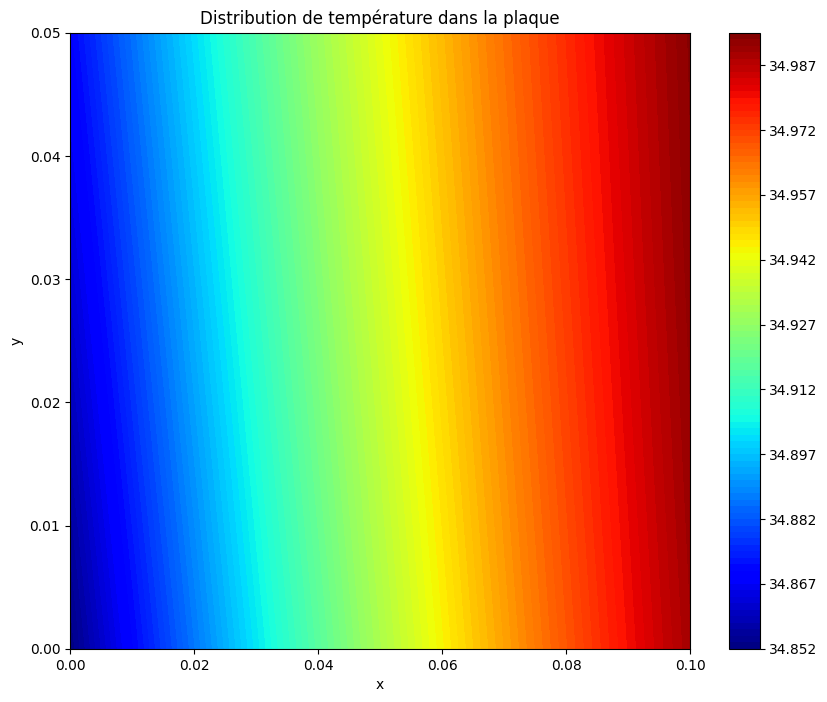

In [157]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Paramètres physiques et géométriques
Lx, Ly = 0.1, 0.05  # Dimensions de la plaque (en mètres)
k = 16.2  # Conductivité thermique de l'acier en W/(m*K)
h = 10.0  # Coefficient de convection en W/(m^2*K)
T_inf = 20.0  # Température ambiante (en degrés Celsius)

# Fenêtres avec températures fixées
window1_center = [0.025, 0.025]
window2_center = [0.075, 0.025]
window_size = 0.02  # Taille des fenêtres (en mètres)

T_window1 = 20.0  # Température de la fenêtre 1
T_window2 = 50.0  # Température de la fenêtre 2

# Création de la grille de points dans la plaque
x_Brick = np.linspace(0, Lx, 200)
y_Brick = np.linspace(0, Ly, 100)
X_Brick, Y_Brick = np.meshgrid(x_Brick, y_Brick)
X_Brick_flat = X_Brick.flatten()[:, None]
Y_Brick_flat = Y_Brick.flatten()[:, None]

# Fonction pour vérifier si un point est dans une fenêtre
def in_window1(x, y):
    return (window1_center[0] - window_size / 2 <= x <= window1_center[0] + window_size / 2) and (window1_center[1] - window_size / 2 <= y <= window1_center[1] + window_size / 2)

def in_window2(x, y):
    return (window2_center[0] - window_size / 2 <= x <= window2_center[0] + window_size / 2) and (window2_center[1] - window_size / 2 <= y <= window2_center[1] + window_size / 2)

# Conditions aux limites
def dirichlet_condition(x, y):
    if in_window1(x, y):
        return T_window1
    elif in_window2(x, y):
        return T_window2
    else:
        return None  # Pour les points hors des fenêtres

# Modèle PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, X):
        for i in range(len(self.layers) - 1):
            X = torch.tanh(self.layers[i](X))
        return self.layers[-1](X)

# Fonction de perte
def loss(model, X_f, X_u, u, h=10.0, T_inf=20.0):
    X_f.requires_grad = True
    u_pred = model(X_f)
    T = u_pred[:, 0]
    
    T_x = torch.autograd.grad(T, X_f, grad_outputs=torch.ones_like(T), create_graph=True)[0][:, 0]
    T_y = torch.autograd.grad(T, X_f, grad_outputs=torch.ones_like(T), create_graph=True)[0][:, 1]
    
    T_xx = torch.autograd.grad(T_x, X_f, grad_outputs=torch.ones_like(T_x), create_graph=True)[0][:, 0]
    T_yy = torch.autograd.grad(T_y, X_f, grad_outputs=torch.ones_like(T_y), create_graph=True)[0][:, 1]

    # Équation de la chaleur avec convection
    f_pred = k * (T_xx + T_yy) + h * (T - T_inf)
    
    # Conditions aux limites Dirichlet
    bc_pred = model(X_u)
    bc_loss = torch.mean((bc_pred - u) ** 2)
    
    # Fonction de perte totale
    loss_f = torch.mean(f_pred ** 2)
    loss_total = loss_f + bc_loss
    return loss_total

# Génération des données de formation
X_f_train = torch.tensor(np.hstack((X_Brick_flat, Y_Brick_flat)), dtype=torch.float32)

# Points de condition aux limites (fenêtres)
X_u_train = []
u_train = []
for x, y in zip(X_Brick_flat, Y_Brick_flat):
    T_bc = dirichlet_condition(x[0], y[0])
    if T_bc is not None:
        X_u_train.append([x[0], y[0]])
        u_train.append([T_bc])

X_u_train = torch.tensor(X_u_train, dtype=torch.float32)
u_train = torch.tensor(u_train, dtype=torch.float32)

# Créer le modèle et l'optimiseur
model = PINN([2, 50, 50, 50, 1])  # 2 entrées (x, y) et 1 sortie (T)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    train_loss = loss(model, X_f_train, X_u_train, u_train)
    train_loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

# Prédiction
output = model(torch.tensor(np.hstack((X_Brick_flat, Y_Brick_flat)), dtype=torch.float32)).detach().numpy().reshape(100, 200)

# Affichage des résultats
plt.figure(figsize=(10, 8))
plt.contourf(X_Brick, Y_Brick, output, levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Distribution de température dans la plaque')
plt.show()


Epoch 0, Loss: 81550.2578125
Epoch 1000, Loss: 56185.5703125
Epoch 2000, Loss: 51553.8359375
Epoch 3000, Loss: 51059.98046875
Epoch 4000, Loss: 28623.990234375
Epoch 5000, Loss: 26678.69140625
Epoch 6000, Loss: 26268.5703125
Epoch 7000, Loss: 25859.921875
Epoch 8000, Loss: 25268.607421875
Epoch 9000, Loss: 24646.6328125


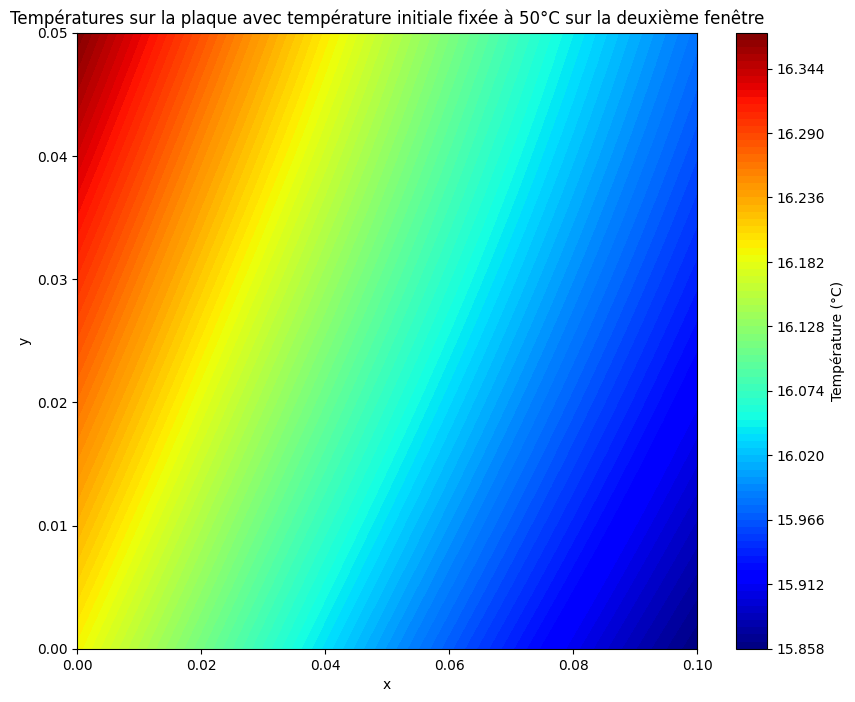

In [39]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Paramètres géométriques et dimensions (en mètres)
mm = 1e-3  # Conversion millimètre en mètre
dx_Brick = 100 * mm
dy_Brick = 50 * mm
e_layer = 1 * mm
dx_Win1 = 20 * mm
dy_Win1 = 20 * mm
dx_Win2 = 20 * mm
dy_Win2 = 20 * mm
xc_Win1 = 25 * mm
yc_Win1 = dy_Brick / 2
xc_Win2 = 75 * mm
yc_Win2 = dy_Brick / 2

# Paramètres du maillage
MeshRefinement = 1  # Raffinement du maillage (1 = grossier, 0.1 = fin)
lc_Brick = dy_Brick / 20 * MeshRefinement
lc_Win1 = dx_Win1 / 10 * MeshRefinement
lc_Win2 = dx_Win2 / 10 * MeshRefinement

# Paramètres thermiques
lambda_Brick = 50.0  # Conductivité thermique pour l'acier (W/mK)
lambda_Layer = 1.0    # Conductivité thermique de la couche (W/mK)
T_Dirichlet = 20.0    # Température imposée pour Dirichlet (°C)
T_Window2 = 50.0      # Température fixée à 50°C sur la deuxième fenêtre

# Définir les fenêtres avec des sources chaudes et froides
def in_window1(x, y):
    return (xc_Win1 - dx_Win1 / 2 <= x <= xc_Win1 + dx_Win1 / 2) and (yc_Win1 - dy_Win1 / 2 <= y <= yc_Win1 + dy_Win1 / 2)

def in_window2(x, y):
    return (xc_Win2 - dx_Win2 / 2 <= x <= xc_Win2 + dx_Win2 / 2) and (yc_Win2 - dy_Win2 / 2 <= y <= yc_Win2 + dy_Win2 / 2)

# Conditions initiales et aux limites
def initial_condition(x, y):
    # Initialiser la température à 20°C partout, sauf sur la deuxième fenêtre où elle est de 50°C
    return np.array([50.0 if in_window2(xi, yi) else 20.0 for xi, yi in zip(x, y)]).reshape(-1, 1)

def dirichlet_condition(x, y):
    return np.full((len(x), 1), T_Dirichlet)  # Température fixée à T_Dirichlet

def source_condition(x, y):
    # Définition des sources dans la fenêtre 1
    return np.array([-1000 if in_window1(xi, yi) else 0 for xi, yi in zip(x, y)]).reshape(-1, 1)

# Définir le modèle PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, X):
        for i in range(len(self.layers) - 1):
            X = torch.tanh(self.layers[i](X))
        return self.layers[-1](X)

# Définir la fonction de perte
def loss_fn(model, X_f, X_u, u, weight_ic=1):
    X_f.requires_grad = True
    u_pred = model(X_f)
    T = u_pred[:, 0]
    
    T_x = torch.autograd.grad(T, X_f, grad_outputs=torch.ones_like(T), create_graph=True)[0][:, 0]
    T_y = torch.autograd.grad(T, X_f, grad_outputs=torch.ones_like(T), create_graph=True)[0][:, 1]
    
    T_xx = torch.autograd.grad(T_x, X_f, grad_outputs=torch.ones_like(T_x), create_graph=True)[0][:, 0]
    T_yy = torch.autograd.grad(T_y, X_f, grad_outputs=torch.ones_like(T_y), create_graph=True)[0][:, 1]

    # Équation de la chaleur avec conduction et sources
    source_term = torch.tensor(source_condition(X_f[:, 0].detach().numpy(), X_f[:, 1].detach().numpy()), dtype=torch.float32)
    f_pred = lambda_Brick * (T_xx + T_yy) + source_term.squeeze()
    
    # Conditions aux limites Dirichlet
    bc_pred_dirichlet = model(X_u)
    bc_loss_dirichlet = torch.mean((bc_pred_dirichlet - torch.tensor(dirichlet_condition(X_u[:, 0].detach().numpy(), X_u[:, 1].detach().numpy()), dtype=torch.float32)) ** 2)
    
    # Conditions initiales
    ic_loss = torch.mean((u_pred - u) ** 2)
    
    # Fonction de perte totale
    loss = torch.mean(f_pred ** 2) + weight_ic * ic_loss + bc_loss_dirichlet
    return loss

# Génération des données de formation (points de maillage)
x_Brick = np.linspace(0, dx_Brick, int(dx_Brick / lc_Brick))
y_Brick = np.linspace(0, dy_Brick, int(dy_Brick / lc_Brick))
X_Brick, Y_Brick = np.meshgrid(x_Brick, y_Brick)
X_Brick_flat = X_Brick.flatten()[:, None]
Y_Brick_flat = Y_Brick.flatten()[:, None]

X_f_train = torch.tensor(np.hstack((X_Brick_flat, Y_Brick_flat)), dtype=torch.float32)
X_u_train = torch.tensor(np.hstack((X_Brick_flat, Y_Brick_flat)), dtype=torch.float32)
u_train = torch.tensor(initial_condition(X_Brick_flat.flatten(), Y_Brick_flat.flatten()), dtype=torch.float32)

# Créer le modèle et l'optimiseur
model = PINN([2, 50, 50, 50, 1])  # 2 entrées (x, y) et 1 sortie (T)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    train_loss = loss_fn(model, X_f_train, X_u_train, u_train)
    train_loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

# Prédiction
output = model(torch.tensor(np.hstack((X_Brick_flat, Y_Brick_flat)), dtype=torch.float32)).detach().numpy().reshape(len(y_Brick), len(x_Brick))

# Affichage des résultats
plt.figure(figsize=(10, 8))
plt.contourf(X_Brick, Y_Brick, output, levels=100, cmap='jet')
plt.colorbar(label="Température (°C)")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Températures sur la plaque avec température initiale fixée à 50°C sur la deuxième fenêtre')
plt.show()


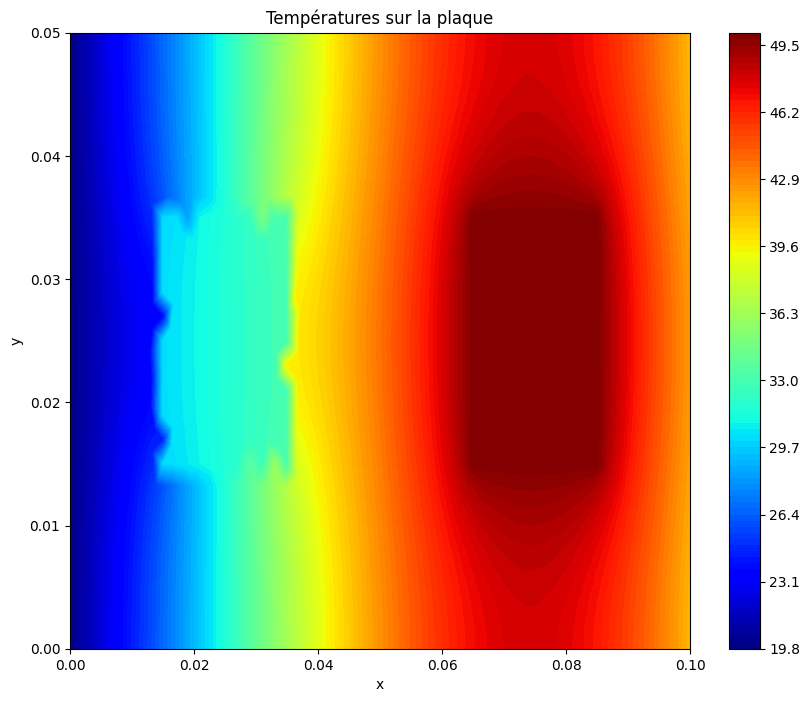

In [72]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

# Fonction pour lire le fichier et extraire les données
def read_data_from_file(filepath):
    with open(filepath, 'r') as file:
        content = file.read()
    
    # Extraire les triangles et les températures
    pattern = re.compile(r'ST\(([^)]+)\)\{([^\}]+)\}')
    matches = pattern.findall(content)
    
    triangles = []
    temperatures = []
    
    for match in matches:
        coords = list(map(float, match[0].split(',')))
        temps = list(map(float, match[1].split(',')))
        triangles.append(coords)
        temperatures.append(temps)
    
    triangles = np.array(triangles)
    temperatures = np.array(temperatures)
    
    return triangles, temperatures

# Chemin d'accès au fichier
filepath = 'C:/Users/TOUGERON/Downloads/T.pos'  # Remplacez ceci par le chemin d'accès réel

# Lire les données du fichier
triangles, temperatures = read_data_from_file(filepath)

# Préparer les données pour le tracé
X = triangles[:, [0, 3, 6]].flatten()
Y = triangles[:, [1, 4, 7]].flatten()
T = temperatures.flatten()

# Triangulation
triang = Triangulation(X, Y)

# Plot des résultats
plt.figure(figsize=(10, 8))
plt.tricontourf(triang, T, levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Températures sur la plaque')
plt.show()


In [165]:
import torch
import torch.nn as nn

# Définir le réseau de neurones
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Entrée: (x, y)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)  # Sortie: u(x, y)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.fc4(x)

# Définir l'équation de la chaleur en régime stationnaire (Laplace)
def heat_equation_loss(model, x):
    u = model(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x[:, 0], x, torch.ones_like(u_x[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_x[:, 1], x, torch.ones_like(u_x[:, 1]), create_graph=True)[0][:, 1]
    return (u_xx + u_yy).pow(2).mean()

# Conditions aux limites
def boundary_loss(model, x_boundary, u_boundary):
    u_pred = model(x_boundary)
    return nn.MSELoss()(u_pred, u_boundary)

# Entraînement
def train(model, optimizer, x_interior, x_boundary, u_boundary, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Calculer les pertes
        loss_interior = heat_equation_loss(model, x_interior)
        loss_boundary = boundary_loss(model, x_boundary, u_boundary)

        # Total loss
        loss = loss_interior + loss_boundary

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item()}')

# Domaine: carré unité [0, 1] x [0, 1]
x_interior = torch.rand(1000, 2, requires_grad=True)
x_boundary = torch.cat([torch.rand(250, 2) * torch.tensor([1.0, 0.0]) + torch.tensor([0.0, y]) for y in [0.0, 1.0]] +
                       [torch.rand(250, 2) * torch.tensor([0.0, 1.0]) + torch.tensor([x, 0.0]) for x in [0.0, 1.0]])

u_boundary = torch.zeros(x_boundary.shape[0], 1)  # Condition aux limites : température nulle sur les bords

# Initialiser le modèle et l'optimiseur
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
train(model, optimizer, x_interior, x_boundary, u_boundary, epochs=5000)

# Tester la solution
with torch.no_grad():
    x_test = torch.tensor([[0.5, 0.5]], requires_grad=True)
    u_test = model(x_test)
    print(f'Temperature at (0.5, 0.5): {u_test.item()}')


Epoch 0: Loss = 0.029824072495102882
Epoch 100: Loss = 7.979743531905115e-05
Epoch 200: Loss = 1.9056606106460094e-05
Epoch 300: Loss = 5.141415840625996e-06
Epoch 400: Loss = 2.7494643290992826e-06
Epoch 500: Loss = 2.231251528428402e-06
Epoch 600: Loss = 1.951351805473678e-06
Epoch 700: Loss = 1.7401976037945133e-06
Epoch 800: Loss = 1.567675326441531e-06
Epoch 900: Loss = 1.4207407730282284e-06
Epoch 1000: Loss = 1.2929407375850133e-06
Epoch 1100: Loss = 1.1806268958025612e-06
Epoch 1200: Loss = 1.0812984783115098e-06
Epoch 1300: Loss = 9.929059388014139e-07
Epoch 1400: Loss = 9.136912240137463e-07
Epoch 1500: Loss = 8.421734492003452e-07
Epoch 1600: Loss = 7.771434411552036e-07
Epoch 1700: Loss = 7.176402050390607e-07
Epoch 1800: Loss = 6.629232984778355e-07
Epoch 1900: Loss = 6.124292895037797e-07
Epoch 2000: Loss = 5.657244628309854e-07
Epoch 2100: Loss = 5.22484413068014e-07
Epoch 2200: Loss = 4.824371444556164e-07
Epoch 2300: Loss = 4.453661404113518e-07
Epoch 2400: Loss = 4.11

Epoch 0: Loss = 624.2522583007812
Epoch 100: Loss = 540.85009765625
Epoch 200: Loss = 505.0126647949219
Epoch 300: Loss = 486.3389892578125
Epoch 400: Loss = 465.7469482421875
Epoch 500: Loss = 413.083740234375
Epoch 600: Loss = 373.12548828125
Epoch 700: Loss = 344.4353942871094
Epoch 800: Loss = 319.5606689453125
Epoch 900: Loss = 298.2138977050781
Epoch 1000: Loss = 279.7333679199219
Epoch 1100: Loss = 261.2294006347656
Epoch 1200: Loss = 243.1200714111328
Epoch 1300: Loss = 226.06500244140625
Epoch 1400: Loss = 211.15005493164062
Epoch 1500: Loss = 197.47708129882812
Epoch 1600: Loss = 185.08880615234375
Epoch 1700: Loss = 173.5898895263672
Epoch 1800: Loss = 163.64242553710938
Epoch 1900: Loss = 162.57730102539062
Epoch 2000: Loss = 146.6992645263672
Epoch 2100: Loss = 139.5771942138672
Epoch 2200: Loss = 136.79054260253906
Epoch 2300: Loss = 127.0235595703125
Epoch 2400: Loss = 121.40814971923828
Epoch 2500: Loss = 115.9762954711914
Epoch 2600: Loss = 109.9623031616211
Epoch 2700

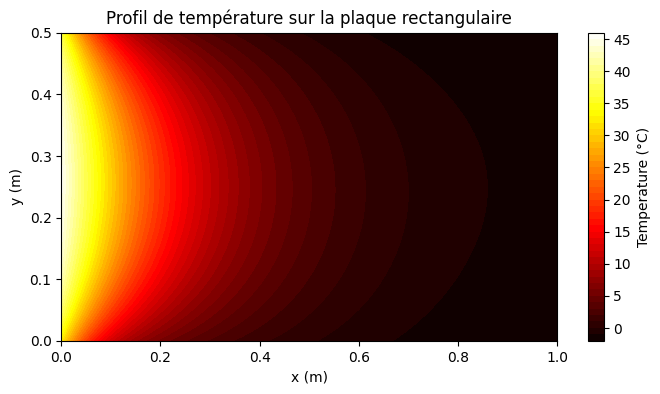

In [167]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Définir le réseau de neurones
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Entrée: (x, y)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)  # Sortie: u(x, y)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.fc4(x)

# Définir l'équation de la chaleur en régime stationnaire (Laplace)
def heat_equation_loss(model, x):
    u = model(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x[:, 0], x, torch.ones_like(u_x[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_x[:, 1], x, torch.ones_like(u_x[:, 1]), create_graph=True)[0][:, 1]
    return (u_xx + u_yy).pow(2).mean()

# Conditions aux limites
def boundary_loss(model, x_boundary, u_boundary):
    u_pred = model(x_boundary)
    return nn.MSELoss()(u_pred, u_boundary)

# Entraînement
def train(model, optimizer, x_interior, x_boundary, u_boundary, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Calculer les pertes
        loss_interior = heat_equation_loss(model, x_interior)
        loss_boundary = boundary_loss(model, x_boundary, u_boundary)

        # Total loss
        loss = loss_interior + loss_boundary

        # Spécifier retain_graph=True pour éviter l'erreur lors de la rétropropagation multiple
        loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item()}')

# Paramètres du domaine
Lx, Ly = 1.0, 0.5  # Dimensions de la plaque (rectangulaire)

# Points intérieurs dans le domaine [0, Lx] x [0, Ly]
x_interior = torch.rand(1000, 2, requires_grad=True) * torch.tensor([Lx, Ly])

# Points sur les frontières
x_boundary_left = torch.cat([torch.zeros(250, 1), torch.rand(250, 1) * Ly], dim=1)  # x = 0, chauffé à 50°C
x_boundary_right = torch.cat([Lx * torch.ones(250, 1), torch.rand(250, 1) * Ly], dim=1)  # x = Lx, 0°C
x_boundary_bottom = torch.cat([torch.rand(250, 1) * Lx, torch.zeros(250, 1)], dim=1)  # y = 0, 0°C
x_boundary_top = torch.cat([torch.rand(250, 1) * Lx, Ly * torch.ones(250, 1)], dim=1)  # y = Ly, 0°C

x_boundary = torch.cat([x_boundary_left, x_boundary_right, x_boundary_bottom, x_boundary_top])
u_boundary = torch.cat([50 * torch.ones(250, 1),  # Température 50°C sur le côté gauche
                        torch.zeros(750, 1)])  # Température 0°C sur les autres côtés

# Initialiser le modèle et l'optimiseur
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
train(model, optimizer, x_interior, x_boundary, u_boundary, epochs=5000)

# Tester et visualiser la solution
with torch.no_grad():
    # Grille de points pour la visualisation
    x = np.linspace(0, Lx, 100)
    y = np.linspace(0, Ly, 50)
    X, Y = np.meshgrid(x, y)
    XY = torch.tensor(np.column_stack([X.ravel(), Y.ravel()]), dtype=torch.float32)
    
    # Prédire les températures
    u_pred = model(XY).reshape(X.shape).detach().numpy()
    
    # Tracer le profil de température
    plt.figure(figsize=(8, 4))
    plt.contourf(X, Y, u_pred, 50, cmap='hot')
    plt.colorbar(label="Temperature (°C)")
    plt.title("Profil de température sur la plaque rectangulaire")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.show()


Epoch 0: Loss = 556.975830078125
Epoch 100: Loss = 394.0848388671875
Epoch 200: Loss = 299.17926025390625
Epoch 300: Loss = 237.86306762695312
Epoch 400: Loss = 191.62356567382812
Epoch 500: Loss = 156.15821838378906
Epoch 600: Loss = 129.11074829101562
Epoch 700: Loss = 108.77953338623047
Epoch 800: Loss = 93.7929458618164
Epoch 900: Loss = 83.00071716308594
Epoch 1000: Loss = 75.43221282958984
Epoch 1100: Loss = 70.27808380126953
Epoch 1200: Loss = 66.87872314453125
Epoch 1300: Loss = 64.7126235961914
Epoch 1400: Loss = 63.38227462768555
Epoch 1500: Loss = 62.596439361572266
Epoch 1600: Loss = 62.15092849731445
Epoch 1700: Loss = 61.90900802612305
Epoch 1800: Loss = 61.78342056274414
Epoch 1900: Loss = 61.72123718261719
Epoch 2000: Loss = 61.6919059753418
Epoch 2100: Loss = 61.678768157958984
Epoch 2200: Loss = 61.67316818237305
Epoch 2300: Loss = 61.6708984375
Epoch 2400: Loss = 61.67001724243164
Epoch 2500: Loss = 61.669681549072266
Epoch 2600: Loss = 61.66953659057617
Epoch 2700: 

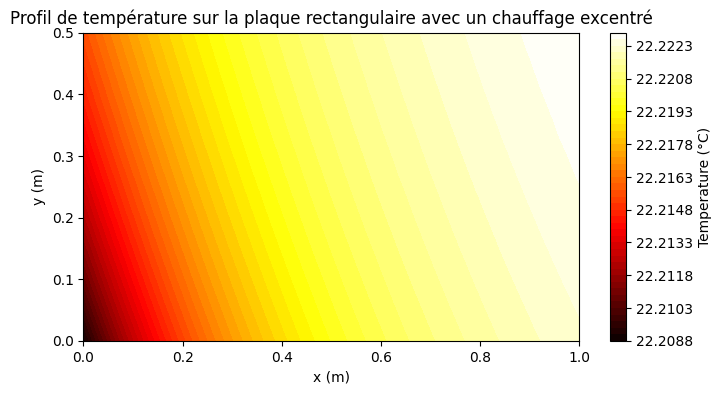

In [168]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Définir le réseau de neurones
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Entrée: (x, y)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)  # Sortie: u(x, y)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.fc4(x)

# Définir l'équation de la chaleur en régime stationnaire (Laplace)
def heat_equation_loss(model, x):
    u = model(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x[:, 0], x, torch.ones_like(u_x[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_x[:, 1], x, torch.ones_like(u_x[:, 1]), create_graph=True)[0][:, 1]
    return (u_xx + u_yy).pow(2).mean()

# Conditions aux limites
def boundary_loss(model, x_boundary, u_boundary):
    u_pred = model(x_boundary)
    return nn.MSELoss()(u_pred, u_boundary)

# Entraînement
def train(model, optimizer, x_interior, x_boundary, u_boundary, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Calculer les pertes
        loss_interior = heat_equation_loss(model, x_interior)
        loss_boundary = boundary_loss(model, x_boundary, u_boundary)

        # Total loss
        loss = loss_interior + loss_boundary

        # Spécifier retain_graph=True pour éviter l'erreur lors de la rétropropagation multiple
        loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item()}')

# Paramètres du domaine
Lx, Ly = 1.0, 0.5  # Dimensions de la plaque (rectangulaire)

# Définir le rectangle chauffé (excentré à droite)
# On suppose que le rectangle est défini par les coordonnées x dans [0.6*Lx, 0.9*Lx] et y dans [0.2*Ly, 0.4*Ly]
x_rect = [0.6 * Lx, 0.9 * Lx]
y_rect = [0.2 * Ly, 0.4 * Ly]

# Points intérieurs dans le domaine [0, Lx] x [0, Ly]
x_interior = torch.rand(1000, 2, requires_grad=True) * torch.tensor([Lx, Ly])

# Points sur les frontières (et à l'intérieur du rectangle chauffé)
x_boundary_outside = torch.cat([torch.rand(500, 2) * torch.tensor([Lx, Ly])], dim=0)

# Masque pour les points qui sont à l'intérieur du rectangle chauffé
mask_rect = (x_boundary_outside[:, 0] >= x_rect[0]) & (x_boundary_outside[:, 0] <= x_rect[1]) & \
            (x_boundary_outside[:, 1] >= y_rect[0]) & (x_boundary_outside[:, 1] <= y_rect[1])

x_boundary_heated = x_boundary_outside[mask_rect]  # Points à l'intérieur du rectangle chauffé
x_boundary_cool = x_boundary_outside[~mask_rect]   # Points en dehors du rectangle chauffé

# Températures correspondantes
u_boundary_heated = 50 * torch.ones(x_boundary_heated.shape[0], 1)  # 50°C à l'intérieur du rectangle
u_boundary_cool = 20 * torch.ones(x_boundary_cool.shape[0], 1)      # 20°C ailleurs

# Regrouper toutes les conditions aux limites
x_boundary = torch.cat([x_boundary_heated, x_boundary_cool])
u_boundary = torch.cat([u_boundary_heated, u_boundary_cool])

# Initialiser le modèle et l'optimiseur
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
train(model, optimizer, x_interior, x_boundary, u_boundary, epochs=5000)

# Tester et visualiser la solution
with torch.no_grad():
    # Grille de points pour la visualisation
    x = np.linspace(0, Lx, 100)
    y = np.linspace(0, Ly, 50)
    X, Y = np.meshgrid(x, y)
    XY = torch.tensor(np.column_stack([X.ravel(), Y.ravel()]), dtype=torch.float32)
    
    # Prédire les températures
    u_pred = model(XY).reshape(X.shape).detach().numpy()
    
    # Tracer le profil de température
    plt.figure(figsize=(8, 4))
    plt.contourf(X, Y, u_pred, 50, cmap='hot')
    plt.colorbar(label="Temperature (°C)")
    plt.title("Profil de température sur la plaque rectangulaire avec un chauffage excentré")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.show()


In [170]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Définir le réseau de neurones avec plus de couches et de neurones
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 50)  # Augmenter le nombre de neurones
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 50)
        self.fc5 = nn.Linear(50, 1)  # Sortie: u(x, y)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        return self.fc5(x)

# Définir l'équation de la chaleur en régime stationnaire (Laplace)
def heat_equation_loss(model, x):
    u = model(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x[:, 0], x, torch.ones_like(u_x[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_x[:, 1], x, torch.ones_like(u_x[:, 1]), create_graph=True)[0][:, 1]
    return (u_xx + u_yy).pow(2).mean()

# Conditions aux limites
def boundary_loss(model, x_boundary, u_boundary):
    u_pred = model(x_boundary)
    return nn.MSELoss()(u_pred, u_boundary)

# Entraînement
def train(model, optimizer, x_interior, x_boundary, u_boundary, epochs=2000):
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Calculer les pertes
        loss_interior = heat_equation_loss(model, x_interior)
        loss_boundary = boundary_loss(model, x_boundary, u_boundary)

        # Total loss
        loss = loss_interior + loss_boundary

        # Spécifier retain_graph=True pour éviter l'erreur lors de la rétropropagation multiple
        loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item()}')

# Paramètres du domaine
Lx, Ly = 1.0, 0.5  # Dimensions de la plaque (rectangulaire)

# Définir le rectangle chauffé (excentré à droite)
# On suppose que le rectangle est défini par les coordonnées x dans [0.6*Lx, 0.9*Lx] et y dans [0.2*Ly, 0.4*Ly]
x_rect = [0.6 * Lx, 0.9 * Lx]
y_rect = [0.2 * Ly, 0.4 * Ly]

# Points intérieurs dans le domaine [0, Lx] x [0, Ly]
x_interior = torch.rand(5000, 2, requires_grad=True) * torch.tensor([Lx, Ly])  # Augmentation du nombre de points intérieurs

# Points sur les frontières (et à l'intérieur du rectangle chauffé)
x_boundary_outside = torch.rand(2000, 2) * torch.tensor([Lx, Ly])  # Augmentation du nombre de points aux limites

# Masque pour les points qui sont à l'intérieur du rectangle chauffé
mask_rect = (x_boundary_outside[:, 0] >= x_rect[0]) & (x_boundary_outside[:, 0] <= x_rect[1]) & \
            (x_boundary_outside[:, 1] >= y_rect[0]) & (x_boundary_outside[:, 1] <= y_rect[1])

x_boundary_heated = x_boundary_outside[mask_rect]  # Points à l'intérieur du rectangle chauffé
x_boundary_cool = x_boundary_outside[~mask_rect]   # Points en dehors du rectangle chauffé

# Températures correspondantes
u_boundary_heated = 50 * torch.ones(x_boundary_heated.shape[0], 1)  # 50°C à l'intérieur du rectangle
u_boundary_cool = 20 * torch.ones(x_boundary_cool.shape[0], 1)      # 20°C ailleurs

# Regrouper toutes les conditions aux limites
x_boundary = torch.cat([x_boundary_heated, x_boundary_cool])
u_boundary = torch.cat([u_boundary_heated, u_boundary_cool])

# Initialiser le modèle et l'optimiseur
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
train(model, optimizer, x_interior, x_boundary, u_boundary, epochs=10000)

# Tester et visualiser la solution
with torch.no_grad():
    # Grille de points pour la visualisation
    x = np.linspace(0, Lx, 100)
    y = np.linspace(0, Ly, 50)
    X, Y = np.meshgrid(x, y)
    XY = torch.tensor(np.column_stack([X.ravel(), Y.ravel()]), dtype=torch.float32)
    
    # Prédire les températures
    u_pred = model(XY).reshape(X.shape).detach().numpy()
    
    # Tracer le profil de température
    plt.figure(figsize=(8, 4))
    plt.contourf(X, Y, u_pred, 50, cmap='hot')
    plt.colorbar(label="Temperature (°C)")
    plt.title("Profil de température sur la plaque rectangulaire avec un chauffage excentré")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.show()


Epoch 0: Loss = 525.5118408203125
Epoch 100: Loss = 209.33775329589844
Epoch 200: Loss = 116.76434326171875
Epoch 300: Loss = 73.83012390136719
Epoch 400: Loss = 56.261531829833984
Epoch 500: Loss = 50.20332717895508


KeyboardInterrupt: 

In [179]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Définition du réseau de neurones
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()  # Fonction d'activation
        self.layers = nn.ModuleList()

        # Construction des couches du réseau
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Génération de points dans le domaine et sur les frontières
def generate_points(N_interior, N_boundary, Lx, Ly):
    # Points internes à la plaque (x, y)
    x_interior = np.random.uniform(0, Lx, (N_interior, 1))
    y_interior = np.random.uniform(0, Ly, (N_interior, 1))

    # Points sur les bords de la plaque
    x_boundary_top = np.linspace(0, Lx, N_boundary).reshape(-1, 1)
    y_boundary_top = np.ones_like(x_boundary_top) * Ly

    x_boundary_bottom = np.linspace(0, Lx, N_boundary).reshape(-1, 1)
    y_boundary_bottom = np.zeros_like(x_boundary_bottom)

    x_boundary_left = np.zeros_like(x_boundary_bottom)
    y_boundary_left = np.linspace(0, Ly, N_boundary).reshape(-1, 1)

    x_boundary_right = np.ones_like(x_boundary_bottom) * Lx
    y_boundary_right = np.linspace(0, Ly, N_boundary).reshape(-1, 1)

    # Conversion en tenseurs PyTorch
    interior = torch.tensor(np.hstack((x_interior, y_interior)), dtype=torch.float32, requires_grad=True)
    boundary_top = torch.tensor(np.hstack((x_boundary_top, y_boundary_top)), dtype=torch.float32)
    boundary_bottom = torch.tensor(np.hstack((x_boundary_bottom, y_boundary_bottom)), dtype=torch.float32)
    boundary_left = torch.tensor(np.hstack((x_boundary_left, y_boundary_left)), dtype=torch.float32)
    boundary_right = torch.tensor(np.hstack((x_boundary_right, y_boundary_right)), dtype=torch.float32)

    return interior, boundary_top, boundary_bottom, boundary_left, boundary_right

# Fonction pour définir la source de chaleur dans une zone rectangulaire
def heat_source(x, y, x_min, x_max, y_min, y_max, q_value):
    # Source de chaleur constante dans une zone rectangulaire [x_min, x_max] x [y_min, y_max]
    condition = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
    return torch.where(condition, q_value, torch.tensor(0.0))

# Fonction de perte du PINN
def loss_function(model, interior, boundaries, T_boundary, x_min, x_max, y_min, y_max, q_value, k):
    # Prédiction pour les points intérieurs
    T_pred = model(interior)

    # Calcul des dérivées secondes (équation de Poisson ∇²T = -q(x,y)/k)
    T_pred_grad = torch.autograd.grad(T_pred, interior, grad_outputs=torch.ones_like(T_pred),
                                      create_graph=True)[0]
    T_pred_x = T_pred_grad[:, 0]
    T_pred_y = T_pred_grad[:, 1]

    T_pred_xx = torch.autograd.grad(T_pred_x, interior, grad_outputs=torch.ones_like(T_pred_x),
                                    create_graph=True)[0][:, 0]
    T_pred_yy = torch.autograd.grad(T_pred_y, interior, grad_outputs=torch.ones_like(T_pred_y),
                                    create_graph=True)[0][:, 1]

    laplacian_T = T_pred_xx + T_pred_yy

    # Source de chaleur q(x, y)
    q = heat_source(interior[:, 0], interior[:, 1], x_min, x_max, y_min, y_max, q_value)

    # Erreur d'équation de Poisson
    loss_interior = torch.mean((laplacian_T + q / k) ** 2)

    # Erreur sur les conditions aux limites (Dirichlet, T = T_boundary)
    loss_boundary = 0
    for i, boundary in enumerate(boundaries):
        T_boundary_pred = model(boundary)  # Appliquez le modèle uniquement aux points de frontière
        T_boundary_true = T_boundary[i].view(-1, 1)  # Assurez-vous que les dimensions correspondent
        loss_boundary += torch.mean((T_boundary_pred - T_boundary_true) ** 2)

    return loss_interior + loss_boundary

# Paramètres du problème
Lx, Ly = 1.0, 1.0  # Dimensions de la plaque (1 m x 1 m)
N_interior = 1000  # Nombre de points internes
N_boundary = 100  # Nombre de points sur chaque bord
k = 50.0  # Conductivité thermique de l'acier en W/m·K

# Température aux bords de la plaque (conditions de Dirichlet)
T_boundary_top = 50.0  # En °C
T_boundary_bottom = 20.0  # En °C
T_boundary_left = 20.0  # En °C
T_boundary_right = 20.0  # En °C

# Paramètres de la zone chauffée
x_min, x_max = 0.4, 0.6  # Limites de la zone chauffée en x
y_min, y_max = 0.4, 0.6  # Limites de la zone chauffée en y
q_value = 100.0  # Puissance de la source de chaleur en W/m²

# Génération des points
interior, boundary_top, boundary_bottom, boundary_left, boundary_right = generate_points(N_interior, N_boundary, Lx, Ly)

boundaries = [boundary_top, boundary_bottom, boundary_left, boundary_right]
T_boundary = [torch.tensor(T_boundary_top * np.ones((N_boundary, 1)), dtype=torch.float32),
              torch.tensor(T_boundary_bottom * np.ones((N_boundary, 1)), dtype=torch.float32),
              torch.tensor(T_boundary_left * np.ones((N_boundary, 1)), dtype=torch.float32),
              torch.tensor(T_boundary_right * np.ones((N_boundary, 1)), dtype=torch.float32)]

# Définition du modèle PINN
layers = [2, 20, 20, 20, 1]  # Architecture du réseau : 2 entrées (x, y) et 1 sortie (T)
model = PINN(layers)

# Optimiseur
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du PINN
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, interior, boundaries, T_boundary, x_min, x_max, y_min, y_max, q_value, k)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Le modèle entraîné peut maintenant être utilisé pour prédire la température en tout point de la plaque.


Epoch 0, Loss: 3654.3447265625
Epoch 500, Loss: 1508.640380859375
Epoch 1000, Loss: 889.3255615234375
Epoch 1500, Loss: 710.3355712890625
Epoch 2000, Loss: 678.1653442382812
Epoch 2500, Loss: 675.0235595703125
Epoch 3000, Loss: 485.4162292480469
Epoch 3500, Loss: 269.02606201171875
Epoch 4000, Loss: 142.51686096191406
Epoch 4500, Loss: 81.90937805175781


Epoch 0, Loss: 2522189.75
Epoch 500, Loss: 2362787.75
Epoch 1000, Loss: 2362499.75
Epoch 1500, Loss: 2362499.75
Epoch 2000, Loss: 2362499.75
Epoch 2500, Loss: 2362499.75
Epoch 3000, Loss: 2362499.75
Epoch 3500, Loss: 2362499.5
Epoch 4000, Loss: 335403.96875
Epoch 4500, Loss: 29320.869140625


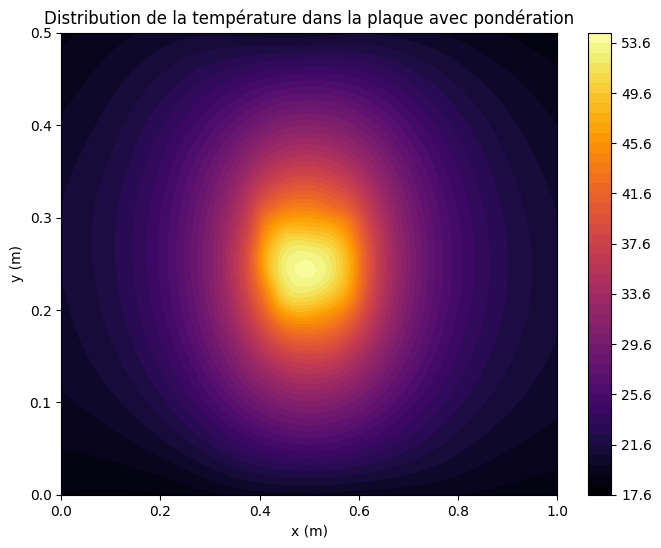

In [215]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Définition du réseau de neurones
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()  # Fonction d'activation
        self.layers = nn.ModuleList()

        # Construction des couches du réseau
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Génération de points dans le domaine et sur les frontières
def generate_points(N_interior, N_boundary, Lx, Ly):
    # Points internes à la plaque (x, y)
    x_interior = np.random.uniform(0, Lx, (N_interior, 1))
    y_interior = np.random.uniform(0, Ly, (N_interior, 1))

    # Points sur les bords de la plaque
    x_boundary_top = np.linspace(0, Lx, N_boundary).reshape(-1, 1)
    y_boundary_top = np.ones_like(x_boundary_top) * Ly

    x_boundary_bottom = np.linspace(0, Lx, N_boundary).reshape(-1, 1)
    y_boundary_bottom = np.zeros_like(x_boundary_bottom)

    x_boundary_left = np.zeros_like(x_boundary_bottom)
    y_boundary_left = np.linspace(0, Ly, N_boundary).reshape(-1, 1)

    x_boundary_right = np.ones_like(x_boundary_bottom) * Lx
    y_boundary_right = np.linspace(0, Ly, N_boundary).reshape(-1, 1)

    # Conversion en tenseurs PyTorch
    interior = torch.tensor(np.hstack((x_interior, y_interior)), dtype=torch.float32, requires_grad=True)
    boundary_top = torch.tensor(np.hstack((x_boundary_top, y_boundary_top)), dtype=torch.float32)
    boundary_bottom = torch.tensor(np.hstack((x_boundary_bottom, y_boundary_bottom)), dtype=torch.float32)
    boundary_left = torch.tensor(np.hstack((x_boundary_left, y_boundary_left)), dtype=torch.float32)
    boundary_right = torch.tensor(np.hstack((x_boundary_right, y_boundary_right)), dtype=torch.float32)

    return interior, boundary_top, boundary_bottom, boundary_left, boundary_right

# Fonction pour définir la source de chaleur dans une zone rectangulaire
def heat_source(x, y, x_min, x_max, y_min, y_max, q_value):
    # Source de chaleur constante dans une zone rectangulaire [x_min, x_max] x [y_min, y_max]
    condition = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
    return torch.where(condition, q_value, torch.tensor(0.0))

# Fonction de perte du PINN avec pondération et respect strict des conditions aux limites
def loss_function(model, interior, boundaries, T_boundary, x_min, x_max, y_min, y_max, q_value, k, weight_interior=1.0, weight_boundary=1.0, weight_heat_zone=5.0):
    # Prédiction pour les points intérieurs
    T_pred = model(interior)

    # Calcul des dérivées secondes (équation de Poisson ∇²T = -q(x,y)/k)
    T_pred_grad = torch.autograd.grad(T_pred, interior, grad_outputs=torch.ones_like(T_pred),
                                      create_graph=True)[0]
    T_pred_x = T_pred_grad[:, 0]
    T_pred_y = T_pred_grad[:, 1]

    T_pred_xx = torch.autograd.grad(T_pred_x, interior, grad_outputs=torch.ones_like(T_pred_x),
                                    create_graph=True)[0][:, 0]
    T_pred_yy = torch.autograd.grad(T_pred_y, interior, grad_outputs=torch.ones_like(T_pred_y),
                                    create_graph=True)[0][:, 1]

    laplacian_T = T_pred_xx + T_pred_yy

    # Source de chaleur q(x, y)
    q = heat_source(interior[:, 0], interior[:, 1], x_min, x_max, y_min, y_max, q_value)

    # Erreur d'équation de Poisson pondérée
    loss_interior = torch.mean((laplacian_T + q / k) ** 2) * weight_interior

    # Erreur sur les conditions aux limites (Dirichlet, T = T_boundary)
    loss_boundary = 0
    for i, boundary in enumerate(boundaries):
        T_boundary_pred = model(boundary)  # Appliquez le modèle uniquement aux points de frontière
        T_boundary_true = T_boundary[i].view(-1, 1)  # Assurez-vous que les dimensions correspondent
        loss_boundary += torch.mean((T_boundary_pred - T_boundary_true) ** 2)

    # Pondération des erreurs sur les frontières
    loss_boundary *= weight_boundary

    return loss_interior + loss_boundary

# Fonction pour prédire la température sur une grille régulière pour la visualisation
def predict_temperature(model, Lx, Ly, resolution=100):
    x = np.linspace(0, Lx, resolution)
    y = np.linspace(0, Ly, resolution)
    X, Y = np.meshgrid(x, y)
    X_flat = X.flatten().reshape(-1, 1)
    Y_flat = Y.flatten().reshape(-1, 1)
    grid_points = torch.tensor(np.hstack((X_flat, Y_flat)), dtype=torch.float32)
    
    with torch.no_grad():
        T_pred = model(grid_points).cpu().numpy()

    T_pred = T_pred.reshape(resolution, resolution)
    return X, Y, T_pred

# Paramètres du problème
Lx, Ly = 1.0, 0.5  # Dimensions de la plaque (1 m x 1 m)
N_interior = 1000  # Nombre de points internes
N_boundary = 200  # Nombre de points sur chaque bord (augmente pour améliorer la résolution des frontières)
k = 50.0  # Conductivité thermique de l'acier en W/m·K

# Température aux bords de la plaque (conditions de Dirichlet)
T_boundary_top = 20.0  # Uniformiser la température à 20°C
T_boundary_bottom = 20.0  # En °C
T_boundary_left = 20.0  # En °C
T_boundary_right = 20.0  # En °C

# Paramètres de la zone chauffée
x_min, x_max = 0.4, 0.6  # Limites de la zone chauffée en x
y_min, y_max = 0.2, 0.3  # Limites de la zone chauffée en y
q_value = 375000.0  # Puissance de la source de chaleur en W/m²

# Génération des points
interior, boundary_top, boundary_bottom, boundary_left, boundary_right = generate_points(N_interior, N_boundary, Lx, Ly)

boundaries = [boundary_top, boundary_bottom, boundary_left, boundary_right]
T_boundary = [torch.tensor(T_boundary_top * np.ones((N_boundary, 1)), dtype=torch.float32),
              torch.tensor(T_boundary_bottom * np.ones((N_boundary, 1)), dtype=torch.float32),
              torch.tensor(T_boundary_left * np.ones((N_boundary, 1)), dtype=torch.float32),
              torch.tensor(T_boundary_right * np.ones((N_boundary, 1)), dtype=torch.float32)]

# Définition du modèle PINN
layers = [2, 20, 20, 20, 20, 20, 20, 50, 50, 50, 1]  # Architecture du réseau : 2 entrées (x, y) et 1 sortie (T)
model = PINN(layers)

# Optimiseur
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du PINN avec pondération des pertes
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, interior, boundaries, T_boundary, x_min, x_max, y_min, y_max, q_value, k, weight_interior=1.0, weight_boundary=100, weight_heat_zone=1.0)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Prédiction de la température sur une grille régulière
X, Y, T_pred = predict_temperature(model, Lx, Ly, resolution=100)

# Visualisation de la température
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, T_pred, levels=50, cmap='inferno')
plt.colorbar(contour)
plt.title("Distribution de la température dans la plaque avec pondération")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()


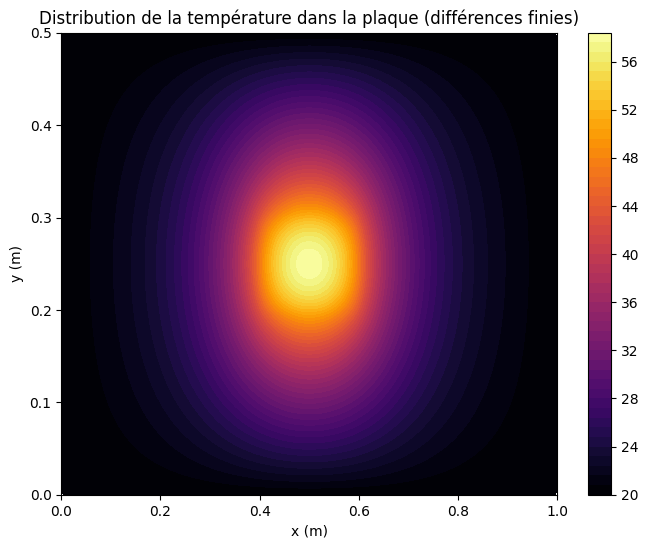

In [229]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du problème
Lx, Ly = 1.0, 0.5  # Dimensions de la plaque (1 m x 0.5 m)
nx, ny = 200, 100  # Nombre de points dans chaque direction
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

k = 50.0  # Conductivité thermique de l'acier en W/m·K
T_boundary = 20.0  # Température aux bords de la plaque

# Source de chaleur
q_value = 375000.0  # Source de chaleur en W/m²
x_min, x_max = 0.4, 0.6  # Limites de la zone chauffée en x
y_min, y_max = 0.2, 0.3  # Limites de la zone chauffée en y

# Création de la grille
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
T = np.full((ny, nx), T_boundary)  # Initialisation de la température à la température de bord

# Discrétisation de l'équation de la chaleur en 2D (différences finies)
for _ in range(5000):  # Nombre d'itérations pour atteindre la convergence
    T_old = T.copy()

    for i in range(1, ny - 1):
        for j in range(1, nx - 1):
            # Vérifier si le point est dans la zone chauffée
            if x_min <= x[j] <= x_max and y_min <= y[i] <= y_max:
                q = q_value
            else:
                q = 0.0

            # Mise à jour de la température en utilisant les différences finies
            T[i, j] = 0.25 * (T_old[i+1, j] + T_old[i-1, j] + T_old[i, j+1] + T_old[i, j-1] + (q * dx**2 / k))

    # Conditions aux limites (température fixe aux bords)
    T[0, :] = T_boundary  # Bord inférieur
    T[-1, :] = T_boundary  # Bord supérieur
    T[:, 0] = T_boundary  # Bord gauche
    T[:, -1] = T_boundary  # Bord droit

# Visualisation de la distribution de température
plt.figure(figsize=(8, 6))
contour = plt.contourf(x, y, T, levels=50, cmap='inferno')
plt.colorbar(contour)
plt.title("Distribution de la température dans la plaque (différences finies)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()


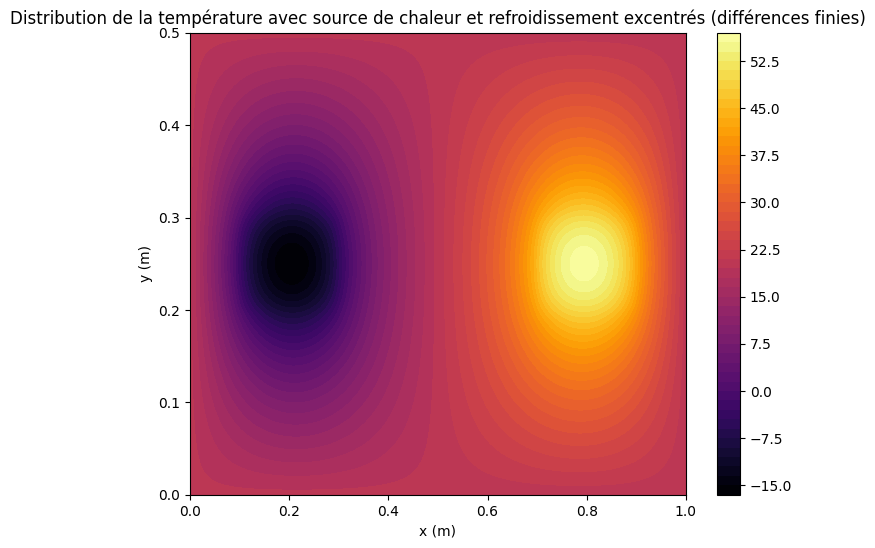

In [249]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du problème
Lx, Ly = 1.0, 0.5  # Dimensions de la plaque (1 m x 0.5 m)
nx, ny = 200, 100  # Nombre de points dans chaque direction
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

k = 50.0  # Conductivité thermique de l'acier en W/m·K
T_boundary = 20.0  # Température aux bords de la plaque

# Source de chaleur
q_value_heating = 375000.0  # Source de chaleur en W/m²
x_min_heat, x_max_heat = 0.7, 0.9  # Limites de la zone chauffée en x (excentrée à droite)
y_min_heat, y_max_heat = 0.2, 0.3  # Limites de la zone chauffée en y

# Source de refroidissement
q_value_cooling = -375000.0  # Source de refroidissement (chaleur négative) en W/m²
x_min_cool, x_max_cool = 0.1, 0.3  # Limites de la zone refroidissante en x (excentrée à gauche)
y_min_cool, y_max_cool = 0.2, 0.3  # Limites de la zone refroidissante en y

# Création de la grille
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
T = np.full((ny, nx), T_boundary)  # Initialisation de la température à la température de bord

# Discrétisation de l'équation de la chaleur en 2D (différences finies)
for _ in range(5000):  # Nombre d'itérations pour atteindre la convergence
    T_old = T.copy()

    for i in range(1, ny - 1):
        for j in range(1, nx - 1):
            # Vérifier si le point est dans la zone chauffée
            if x_min_heat <= x[j] <= x_max_heat and y_min_heat <= y[i] <= y_max_heat:
                q = q_value_heating
            # Vérifier si le point est dans la zone refroidissante
            elif x_min_cool <= x[j] <= x_max_cool and y_min_cool <= y[i] <= y_max_cool:
                q = q_value_cooling
            else:
                q = 0.0

            # Mise à jour de la température en utilisant les différences finies
            T[i, j] = 0.25 * (T_old[i+1, j] + T_old[i-1, j] + T_old[i, j+1] + T_old[i, j-1] + (q * dx**2 / k))

    # Conditions aux limites (température fixe aux bords)
    T[0, :] = T_boundary  # Bord inférieur
    T[-1, :] = T_boundary  # Bord supérieur
    T[:, 0] = T_boundary  # Bord gauche
    T[:, -1] = T_boundary  # Bord droit

# Visualisation de la distribution de température
plt.figure(figsize=(8, 6))
contour = plt.contourf(x, y, T, levels=50, cmap='inferno')
plt.colorbar(contour)
plt.title("Distribution de la température avec source de chaleur et refroidissement excentrés (différences finies)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()


Epoch 0, Loss: 4395400.0
Epoch 500, Loss: 4387518.5
Epoch 1000, Loss: 4387500.0
Epoch 1500, Loss: 4387500.0
Epoch 2000, Loss: 4387500.0
Epoch 2500, Loss: 4387500.0
Epoch 3000, Loss: 4387500.0
Epoch 3500, Loss: 4387500.0
Epoch 4000, Loss: 3418362.5
Epoch 4500, Loss: 1334767.125
Epoch 5000, Loss: 329762.8125
Epoch 5500, Loss: 192101.390625
Epoch 6000, Loss: 101119.375
Epoch 6500, Loss: 168607.453125
Epoch 7000, Loss: 1039502.25
Epoch 7500, Loss: 193578.453125
Epoch 8000, Loss: 130550.390625
Epoch 8500, Loss: 93870.546875
Epoch 9000, Loss: 35709.578125
Epoch 9500, Loss: 25209.33984375


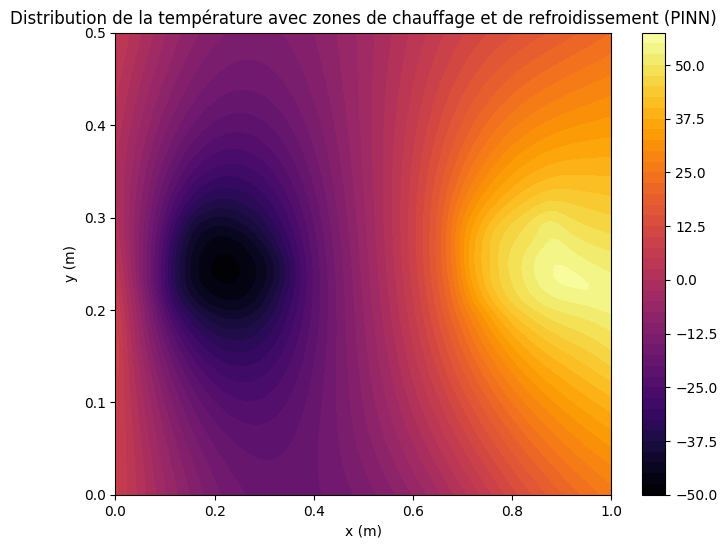

In [263]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Définition du réseau de neurones
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()  # Fonction d'activation
        self.layers = nn.ModuleList()

        # Construction des couches du réseau
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Génération de points dans le domaine et sur les frontières
def generate_points(N_interior, N_boundary, Lx, Ly):
    # Points internes à la plaque (x, y)
    x_interior = np.random.uniform(0, Lx, (N_interior, 1))
    y_interior = np.random.uniform(0, Ly, (N_interior, 1))

    # Points sur les bords de la plaque
    x_boundary_top = np.linspace(0, Lx, N_boundary).reshape(-1, 1)
    y_boundary_top = np.ones_like(x_boundary_top) * Ly

    x_boundary_bottom = np.linspace(0, Lx, N_boundary).reshape(-1, 1)
    y_boundary_bottom = np.zeros_like(x_boundary_bottom)

    x_boundary_left = np.zeros_like(x_boundary_bottom)
    y_boundary_left = np.linspace(0, Ly, N_boundary).reshape(-1, 1)

    x_boundary_right = np.ones_like(x_boundary_bottom) * Lx
    y_boundary_right = np.linspace(0, Ly, N_boundary).reshape(-1, 1)

    # Conversion en tenseurs PyTorch
    interior = torch.tensor(np.hstack((x_interior, y_interior)), dtype=torch.float32, requires_grad=True)
    boundary_top = torch.tensor(np.hstack((x_boundary_top, y_boundary_top)), dtype=torch.float32)
    boundary_bottom = torch.tensor(np.hstack((x_boundary_bottom, y_boundary_bottom)), dtype=torch.float32)
    boundary_left = torch.tensor(np.hstack((x_boundary_left, y_boundary_left)), dtype=torch.float32)
    boundary_right = torch.tensor(np.hstack((x_boundary_right, y_boundary_right)), dtype=torch.float32)

    return interior, boundary_top, boundary_bottom, boundary_left, boundary_right

# Fonction pour définir les sources de chaleur (positives et négatives) dans les zones spécifiées
def heat_source(x, y, heat_zone, cool_zone, q_heat, q_cool):
    # Source de chaleur positive dans la zone chauffée
    condition_heat = (x >= heat_zone[0]) & (x <= heat_zone[1]) & (y >= heat_zone[2]) & (y <= heat_zone[3])
    heat_source = torch.where(condition_heat, q_heat, torch.tensor(0.0))
    
    # Source de refroidissement (chaleur négative) dans la zone refroidissante
    condition_cool = (x >= cool_zone[0]) & (x <= cool_zone[1]) & (y >= cool_zone[2]) & (y <= cool_zone[3])
    cool_source = torch.where(condition_cool, q_cool, torch.tensor(0.0))

    # Superposition des deux sources
    return heat_source + cool_source

# Fonction de perte du PINN avec pondération
def loss_function(model, interior, boundaries, T_boundary, heat_zone, cool_zone, q_heat, q_cool, k, weight_interior=1.0, weight_boundary=1.0):
    # Prédiction pour les points intérieurs
    T_pred = model(interior)

    # Calcul des dérivées secondes (équation de Poisson ∇²T = -q(x,y)/k)
    T_pred_grad = torch.autograd.grad(T_pred, interior, grad_outputs=torch.ones_like(T_pred),
                                      create_graph=True)[0]
    T_pred_x = T_pred_grad[:, 0]
    T_pred_y = T_pred_grad[:, 1]

    T_pred_xx = torch.autograd.grad(T_pred_x, interior, grad_outputs=torch.ones_like(T_pred_x),
                                    create_graph=True)[0][:, 0]
    T_pred_yy = torch.autograd.grad(T_pred_y, interior, grad_outputs=torch.ones_like(T_pred_y),
                                    create_graph=True)[0][:, 1]

    laplacian_T = T_pred_xx + T_pred_yy

    # Sources de chaleur et de refroidissement
    q = heat_source(interior[:, 0], interior[:, 1], heat_zone, cool_zone, q_heat, q_cool)

    # Erreur d'équation de Poisson pondérée
    loss_interior = torch.mean((laplacian_T + q / k) ** 2) * weight_interior

    # Erreur sur les conditions aux limites (Dirichlet, T = T_boundary)
    loss_boundary = 0
    for i, boundary in enumerate(boundaries):
        T_boundary_pred = model(boundary)  # Appliquez le modèle uniquement aux points de frontière
        T_boundary_true = T_boundary[i].view(-1, 1)  # Assurez-vous que les dimensions correspondent
        loss_boundary += torch.mean((T_boundary_pred - T_boundary_true) ** 2)

    # Ponderation des erreurs sur les frontières
    loss_boundary *= weight_boundary

    return loss_interior + loss_boundary

# Fonction pour prédire la température sur une grille régulière pour la visualisation
def predict_temperature(model, Lx, Ly, resolution=100):
    x = np.linspace(0, Lx, resolution)
    y = np.linspace(0, Ly, resolution)
    X, Y = np.meshgrid(x, y)
    X_flat = X.flatten().reshape(-1, 1)
    Y_flat = Y.flatten().reshape(-1, 1)
    grid_points = torch.tensor(np.hstack((X_flat, Y_flat)), dtype=torch.float32)
    
    with torch.no_grad():
        T_pred = model(grid_points).cpu().numpy()

    T_pred = T_pred.reshape(resolution, resolution)
    return X, Y, T_pred

# Paramètres du problème
Lx, Ly = 1.0, 0.5  # Dimensions de la plaque (1 m x 0.5 m)
N_interior = 1000  # Nombre de points internes
N_boundary = 200  # Nombre de points sur chaque bord
k = 50.0  # Conductivité thermique de l'acier en W/m·K

# Température aux bords de la plaque (conditions de Dirichlet)
T_boundary_top = 20.0  # Uniformiser la température à 20°C
T_boundary_bottom = 20.0  # En °C
T_boundary_left = 20.0  # En °C
T_boundary_right = 20.0  # En °C

# Paramètres des zones de chauffage et de refroidissement
heat_zone = [0.7, 0.9, 0.2, 0.3]  # Limites de la zone chauffée en [x_min, x_max, y_min, y_max]
cool_zone = [0.1, 0.3, 0.2, 0.3]  # Limites de la zone refroidissante en [x_min, x_max, y_min, y_max]
q_heat = 375000.0  # Puissance de la source de chaleur en W/m²
q_cool = -375000.0  # Puissance de la source de refroidissement (chaleur négative) en W/m²

# Génération des points
interior, boundary_top, boundary_bottom, boundary_left, boundary_right = generate_points(N_interior, N_boundary, Lx, Ly)

boundaries = [boundary_top, boundary_bottom, boundary_left, boundary_right]
T_boundary = [torch.tensor(T_boundary_top * np.ones((N_boundary, 1)), dtype=torch.float32),
              torch.tensor(T_boundary_bottom * np.ones((N_boundary, 1)), dtype=torch.float32),
              torch.tensor(T_boundary_left * np.ones((N_boundary, 1)), dtype=torch.float32),
              torch.tensor(T_boundary_right * np.ones((N_boundary, 1)), dtype=torch.float32)]

# Définition du modèle PINN
layers = [2, 20, 20, 20, 20, 20, 20, 50, 50, 50, 50,50,50,1]  # Architecture du réseau : 2 entrées (x, y) et 1 sortie (T)
model = PINN(layers)

# Optimiseur
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du PINN avec pondération des pertes
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, interior, boundaries, T_boundary, heat_zone, cool_zone, q_heat, q_cool, k, weight_interior=1.0, weight_boundary=5)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Prédiction de la température sur une grille régulière
X, Y, T_pred = predict_temperature(model, Lx, Ly, resolution=100)

# Visualisation de la température
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, T_pred, levels=50, cmap='inferno')
plt.colorbar(contour)
plt.title("Distribution de la température avec zones de chauffage et de refroidissement (PINN)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()
